In [49]:
import numpy as np
import pandas as pd
import gseapy as gp
import warnings
warnings.filterwarnings('ignore')

dataset_list = ["Braun2020", "GSE100797", "GSE135222", "GSE91061", "GSE93157_LUSC", "GSE93157_nonsqNSCLC", "PRJEB23709", "PRJNA482620", "GSE126044", "GSE145996", "GSE78220", "GSE93157_HNSC", "GSE93157_Melanoma", "phs000452", "PRJEB25780"]
for dataset in dataset_list:
    gem_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/5.Analysis_data/{dataset}/{dataset}.Express.tsv'
    gem = pd.read_csv(gem_path, index_col=0, header=0, delimiter='\t')
    gem.set_index('GENE_SYMBOL', inplace=True)
    
    # normalized
    gem *= 1E5 / gem.sum()
    gem = np.log2(gem + 1)
    gem = gem.subtract(gem.mean(axis=1), axis=0)
    
    gene_sets = '/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/0.model_file/Tres_kegg.Neutrophils.gmt'
    gsva = gp.gsva(data=gem, gene_sets=gene_sets, outdir=None)
    gsva_result = gsva.res2d.pivot(index='Term', columns='Name', values='ES')
    gsva_result.to_csv(f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/5.Analysis_data/{dataset}/{dataset}.gsva.csv')
    print(f'{dataset} calculate GSVA end.')

2024-05-15 13:49:55,779 [WARNING] Input data contains NA, filled NA with 0
2024-05-15 13:50:35,204 [WARNING] Input data contains NA, filled NA with 0


Braun2020 calculate GSVA end.


2024-05-15 13:50:39,767 [WARNING] Input data contains NA, filled NA with 0


GSE100797 calculate GSVA end.
GSE135222 calculate GSVA end.


2024-05-15 13:50:53,659 [WARNING] Input data contains NA, filled NA with 0


GSE91061 calculate GSVA end.


2024-05-15 13:50:56,142 [WARNING] Input data contains NA, filled NA with 0


GSE93157_LUSC calculate GSVA end.
GSE93157_nonsqNSCLC calculate GSVA end.
PRJEB23709 calculate GSVA end.


2024-05-15 13:51:12,123 [WARNING] Input data contains NA, filled NA with 0


PRJNA482620 calculate GSVA end.


2024-05-15 13:51:12,925 [WARNING] Input data contains NA, filled NA with 0


GSE126044 calculate GSVA end.
GSE145996 calculate GSVA end.


2024-05-15 13:51:17,046 [WARNING] Input data contains NA, filled NA with 0


GSE78220 calculate GSVA end.


2024-05-15 13:51:17,717 [WARNING] Input data contains NA, filled NA with 0


GSE93157_HNSC calculate GSVA end.
GSE93157_Melanoma calculate GSVA end.
phs000452 calculate GSVA end.
PRJEB25780 calculate GSVA end.


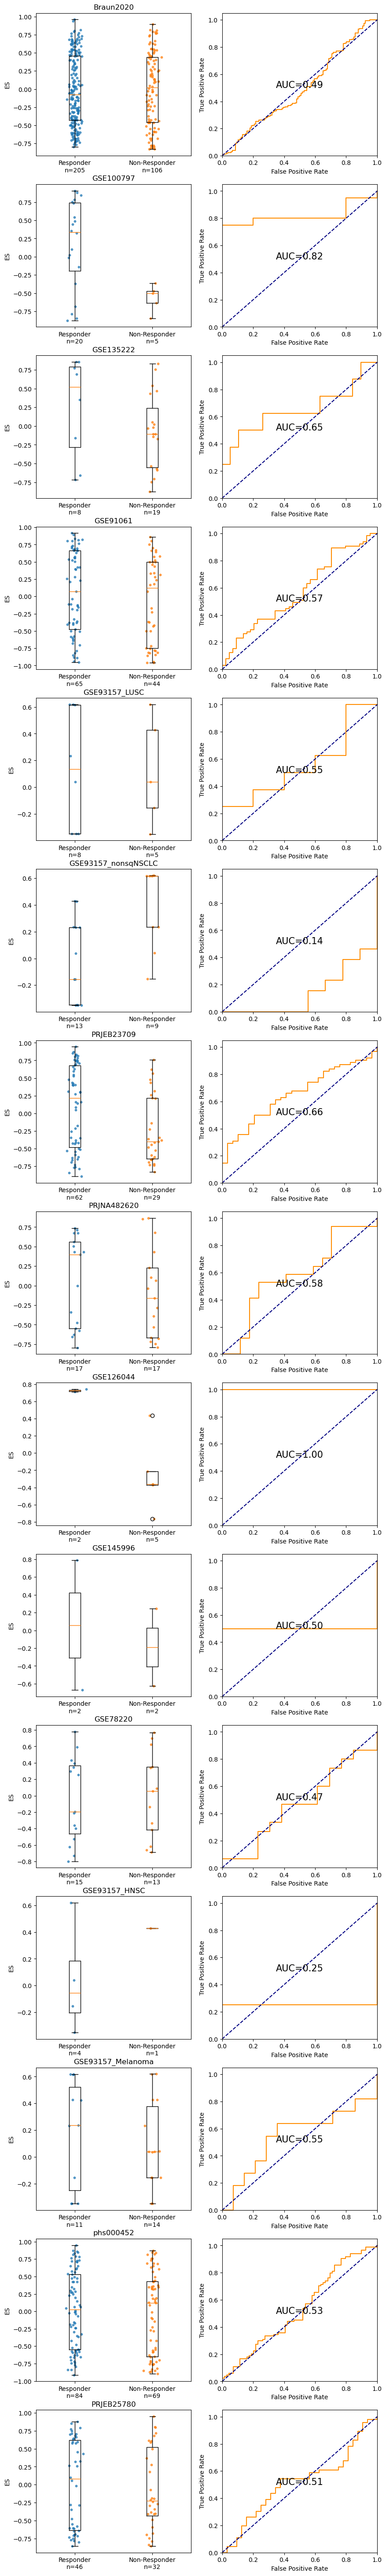

In [51]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import ranksums
from sklearn import metrics

dataset_list = ["Braun2020", "GSE100797", "GSE135222", "GSE91061", "GSE93157_LUSC", "GSE93157_nonsqNSCLC", "PRJEB23709", "PRJNA482620", "GSE126044", "GSE145996", "GSE78220", "GSE93157_HNSC", "GSE93157_Melanoma", "phs000452", "PRJEB25780"]
fig = plt.figure(figsize=(10, 5 * len(dataset_list)))
gs = gridspec.GridSpec(nrows=len(dataset_list), ncols=2, width_ratios=[1, 1])
for i in range(len(dataset_list)):
    dataset = dataset_list[i]
    
    gsva_result_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/5.Analysis_data/{dataset}/{dataset}.gsva.csv'
    gsva_result = pd.read_csv(gsva_result_path, index_col=0, header=0)
    
    sample_annotation_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/5.Analysis_data/{dataset}/{dataset}.Response.tsv'
    sample_annotation_df = pd.read_csv(sample_annotation_path, delimiter='\t', header=0, index_col=0)
    sample_annotation_df.set_index('sample_id', inplace=True)
    
    neutIFN_gsva = gsva_result.loc['Neut_IFN-15']
    # NR_flag = (sample_annotation_df['response'].isin(['PD', 'N']))
    # response_es = neutIFN_gsva.loc[sample_annotation_df[~NR_flag].index]
    # nonresponse_es = neutIFN_gsva.loc[sample_annotation_df[NR_flag].index]
    response_es = neutIFN_gsva.loc[sample_annotation_df[sample_annotation_df['response_NR'] == 'R'].index]
    nonresponse_es = neutIFN_gsva.loc[sample_annotation_df[sample_annotation_df['response_NR'] == 'N'].index]
    
    ax1 = fig.add_subplot(gs[i, 0])
    ax2 = fig.add_subplot(gs[i, 1])
    
    box_data = [np.array(response_es).ravel(), np.array(nonresponse_es).ravel()]
    ax1.boxplot(box_data)
    for i in range(len(box_data)):
        y = box_data[i]
        x = np.random.normal(i + 1, 0.04, size=len(y))
        ax1.scatter(x, y, alpha=0.7, s=10)
    ax1.set_ylabel('ES')
    ax1.set_xticklabels([f'Responder\nn={len(response_es)}', f'Non-Responder\nn={len(nonresponse_es)}'])
    ax1.set_title(f'{dataset}')
        
    # calculate ROC
    y_true = [1] * len(response_es) + [0] * len(nonresponse_es)
    y_pred = list(box_data[0]) + list(box_data[1])
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    ax2.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc})')
    ax2.plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax2.text(0.5, 0.5, f'AUC={"{:.2f}".format(roc_auc)}', ha='center', fontsize=15)
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')

plt.show()

In [40]:
gem_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/5.Analysis_data/Braun2020/Braun2020.Express.tsv'
gem = pd.read_csv(gem_path, index_col=0, header=0, delimiter='\t')
gem.set_index('GENE_SYMBOL', inplace=True)
gene_sets = '/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/0.model_file/Tres_kegg.Neutrophils.gmt'

sample_annotation_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/5.Analysis_data/Braun2020/Braun2020.Response.tsv'
sample_annotation_df = pd.read_csv(sample_annotation_path, delimiter='\t', header=0, index_col=0)
sample_annotation_df.set_index('sample_id', inplace=True)

non_response_flag = sample_annotation_df['response_NR'] == 'N'
response_sample = sample_annotation_df[~non_response_flag].index
nonresponse_sample = sample_annotation_df[non_response_flag].index
cls = ['ALL'] * len(response_sample) + ['AML'] * len(nonresponse_sample)

gs_res = gp.gsea(data=gem,
                 gene_sets=gene_sets, 
                 cls= cls, 
                 # set permutation_type to phenotype if samples >=15
                 permutation_type='phenotype',
                 permutation_num=1000, # reduce number to speed up test
                 outdir=None,  # do not write output to disk
                 method='signal_to_noise',
                 threads=4, seed= 7)
gs_res.res2d.head()

2024-05-15 13:14:54,011 [WARNING] Input data contains NA, filled NA with 0


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,KEGG_COLORECTAL_CANCER,-0.586741,-2.255176,0.0,0.028507,0.01,30/62,16.79%,CTNNB1;RHOA;MAP2K1;PIK3R2;AKT2;PIK3CA;CYCS;MAP...
1,gsea,KEGG_GLIOMA,-0.531589,-2.131511,0.0,0.051924,0.027,39/65,28.00%,IGF1R;E2F3;MAP2K1;PIK3R2;AKT2;PIK3CA;CALM3;RB1...
2,gsea,KEGG_PANCREATIC_CANCER,-0.552016,-2.11943,0.0,0.038688,0.029,33/69,17.97%,JAK1;E2F3;MAP2K1;PIK3R2;RALB;AKT2;RALBP1;PIK3C...
3,gsea,KEGG_GAP_JUNCTION,-0.514229,-2.117897,0.0,0.029016,0.029,46/87,25.95%,MAP2K1;TUBA3E;TUBA1B;CSNK1D;PRKX;TUBA3D;TUBB2B...
4,gsea,KEGG_PATHWAYS_IN_CANCER,-0.436081,-2.087326,0.0,0.03543,0.041,159/320,29.37%,CTNNB1;JAK1;IGF1R;E2F3;RHOA;CTNNA1;MAP2K1;ITGA...


2024-05-15 15:12:05,095 [WARNING] Input data contains NA, filled NA with 0


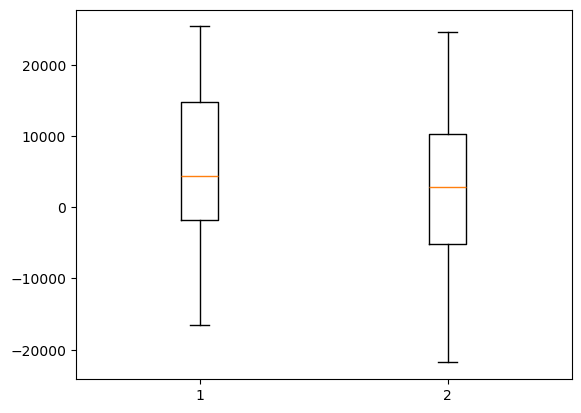

In [55]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

gem_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/5.Analysis_data/Braun2020/Braun2020.Express.tsv'
gem = pd.read_csv(gem_path, index_col=0, header=0, delimiter='\t')
gem.set_index('GENE_SYMBOL', inplace=True)

# normalized
gem *= 1E5 / gem.sum()
gem = np.log2(gem + 1)
gem = gem.subtract(gem.mean(axis=1), axis=0)

gene_sets = '/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/0.model_file/Tres_kegg.Neutrophils.gmt'

sample_annotation_path = f'/sibcb2/bioinformatics2/hongyuyang/dataset/Tres/5.Analysis_data/Braun2020/Braun2020.Response.tsv'
sample_annotation_df = pd.read_csv(sample_annotation_path, delimiter='\t', header=0, index_col=0)
sample_annotation_df.set_index('sample_id', inplace=True)

non_response_flag = sample_annotation_df['response_NR'] == 'N'
response_sample = sample_annotation_df[~non_response_flag].index
nonresponse_sample = sample_annotation_df[non_response_flag].index
cls = ['ALL'] * len(response_sample) + ['AML'] * len(nonresponse_sample)

ss_res = gp.ssgsea(data=gem,
               gene_sets=gene_sets,
               outdir=None,
               sample_norm_method='rank', # choose 'custom' will only use the raw value of `data`
               no_plot=True)
nes = ss_res.res2d.pivot(index='Term', columns='Name', values='ES')
neut_nes = nes.loc['Neut_IFN-15']

response_es = neut_nes.loc[response_sample]
nonresponse_es = neut_nes.loc[nonresponse_sample]

box_data = [np.array(response_es).ravel(), np.array(nonresponse_es).ravel()]
plt.boxplot(box_data)

plt.show()

In [57]:
neut_nes

Name
EA595454        16081.623691
EA595455         9836.917102
EA595473         3398.430893
EA595500          -76.951998
EA595522          3753.34673
                    ...     
RCC_73_T_SCR   -21787.456473
RCC_90_T_SCR    11320.311504
RCC_93_T_SCR    12121.599426
RCC_96_T_SCR   -16773.052772
RCC_99_T_SCR     5205.457199
Name: Neut_IFN-15, Length: 311, dtype: object

In [58]:
response_sample

Index(['G138701_RCCBMS_00097_T_v1_RNA_OnPrem',
       'G138701_RCCBMS_00141_T_v1_RNA_OnPrem',
       'G109543_RCCBMS_00007_T_v1_RNA_OnPrem',
       'G138701_RCCBMS_00154_T_v1_RNA_OnPrem',
       'G138701_RCCBMS_00028_T_v1_RNA_OnPrem',
       'G138701_RCCBMS_00178_T_v1_RNA_OnPrem',
       'G138701_RCCBMS_00072_T_v1_RNA_OnPrem',
       'G109543_RCCBMS_00076_T2_v1_RNA_OnPrem',
       'G138701_RCCBMS_00098_T_v1_RNA_OnPrem',
       'G138701_RCCBMS_00137_T_v1_RNA_OnPrem',
       'G138701_RCCBMS_00169_T_v1_RNA_OnPrem', 'EA639146',
       'P66425_08F_Run1_S7_L001', 'P66507_02A_Run1_S22_L002',
       'P66287_07B_Run1_S2_L001', 'P66425_07A_Run1_S1_L001',
       'P66451_08D_Run1_S23_L002', 'EA595647', 'P66451_07C_Run1_S17_L002',
       'EA595585', 'P66282_01G_Run1_S3_L001', 'P66432_05G_Run1_S6_L001',
       'EA632688', 'P66425_06G_Run1_S30_L002', 'P66511_04E_Run1_S4_L001',
       'EA595632', 'P66432_07E_Run1_S20_L002', 'EA632174',
       'P66287_06H_Run1_S30_L002', 'P66451_08H_Run1_S26_L002', 'EA